<a href="https://colab.research.google.com/github/shernee/CMPE256_SentimentAnalysis/blob/main/CodeBooks/Sentiment_DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install contractions
import contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.3 MB/s 
     |████████████████████████████████| 110 kB 55.0 MB/s 


In [ ]:
import pandas as pd
import gzip
import json
import string
import matplotlib.pyplot as plt
import pickle

##Read the reviews data from multiple product categories

In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_raw = getDF('/content/drive/MyDrive/Patio_Lawn_and_Garden_5.json.gz')

In [ ]:
df_patio = df_raw.sample(n=250000, random_state=4)

In [ ]:
pd.to_pickle(df_patio, '/content/drive/MyDrive/Sentiment_data/patio_reviews_sample_df.pkl')

In [ ]:
df_cellphones = pd.read_pickle('/content/drive/MyDrive/Sentiment_data/cellphone_reviews_sample_df.pkl')
df_grocery = pd.read_pickle('/content/drive/MyDrive/Sentiment_data/grocery_reviews_sample_df.pkl')
df_arts = pd.read_pickle('/content/drive/MyDrive/Sentiment_data/arts_reviews_sample_df.pkl')
df_patio = pd.read_pickle('/content/drive/MyDrive/Sentiment_data/patio_reviews_sample_df.pkl')

In [ ]:
df_cellphones['product'] = 'Cellphones_Accessories'
df_grocery['product'] = 'Grocery_GourmetFoods'
df_arts['product'] = 'Arts_Crafts_Sewing'
df_patio['product'] = 'Patio_Lawn_Garden'

In [ ]:
df_allproducts = pd.concat([df_cellphones, df_grocery, df_arts, df_patio])

##get the counts of reviews in each category

In [ ]:
df_grouped_ratings = df_allproducts.groupby(['product', 'overall']).agg(Count=pd.NamedAgg(column="overall", aggfunc="count")).unstack()
df_grouped_ratings

Count                             
overall                   1.0    2.0    3.0    4.0     5.0
product                                                   
Arts_Crafts_Sewing       7219   6530  14507  30829  190915
Cellphones_Accessories  18051  12676  21954  40752  156567
Grocery_GourmetFoods    10981   9229  17637  32790  179363
Patio_Lawn_Garden       16278  10021  17931  38708  167062

<BarContainer object of 5 artists>

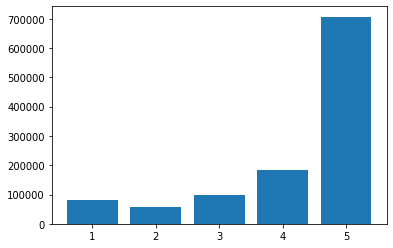

In [ ]:
plt.bar(x=df_rating_count.index, height=df_rating_count['overall'])

In [ ]:
df_allproducts['reviewText'].isna().sum()

437

In [ ]:
df = df_allproducts.dropna(subset=['reviewText'])

In [ ]:
df.shape

(999563, 13)

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Sentiment_data/allproducts_reviews_df.pkl')

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords 
from nltk.stem import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


##Removing the stop words retaining negating words to not lose negative context of the reviews and lemmitizing them

In [ ]:
stopword_list = stopwords.words('english')

stopwords1 = stopword_list[:116]
stopwords2 = stopword_list[119:131]
stopwords3 = stopword_list[133:143]
stopwords4 = ['ma']

new_stopwords_list = stopwords1 + stopwords2 + stopwords3 + stopwords4

In [ ]:
new_punctuation_list = list(string.punctuation) + ['...']
lem = wordnet.WordNetLemmatizer()

def find_line_length(review):
  words_per_review = len(review.split(' '))


  return words_per_review

def find_tokens_and_counts(review):
  expanded_review_text = contractions.fix(review)
  all_tokens = wordpunct_tokenize(expanded_review_text)
  tokens = []
  stopword_count = 0
  punctuation_count = 0

  for token in all_tokens:
    if token not in new_punctuation_list:
      cleaned_token = token.lower().replace(" ","")
      if cleaned_token not in new_stopwords_list:
        tokens.append(cleaned_token)
      else:
        stopword_count+=1
    else:
      punctuation_count+=1
  
  all_tokens_count = len(all_tokens)
  
  return all_tokens_count, tokens, stopword_count, punctuation_count

def find_lemmas(review_tokens):
  lemmatized_tokens = [lem.lemmatize(token) for token in review_tokens]
  lemma_count = len(lemmatized_tokens)
  lemma_str = " ".join(lemmatized_tokens)

  return lemma_count, lemma_str

In [ ]:
df_reviewText = df.loc[:, ['reviewText']]
review_array = df_reviewText['reviewText'].to_numpy()

In [ ]:
review_features = []

for review in review_array:
  feature_dict = {}
  review_length = find_line_length(review)
  num_tokens, tokens_for_lem, num_stopwords, num_punctuations = find_tokens_and_counts(review)
  num_lemmas, lemma_string = find_lemmas(tokens_for_lem)
  feature_dict = {
     "review": review,
     "review_length": review_length,
     "token_count": num_tokens,
     "stopword_count": num_stopwords,
     "punctuation_count": num_punctuations,
     "lemma_count": num_lemmas,
     "lemmas": lemma_string, 
  }

  review_features.append(feature_dict)
df_features = pd.DataFrame(review_features)
df_features.to_pickle('/content/drive/MyDrive/Sentiment_data/all_products_review_features_expanded_df.pkl')

In [ ]:
df_polarity_train = df_features.loc[:, ['review', 'lemmas']]

##Using VADER to label the data as positive and negative

In [ ]:
analyzer = SentimentIntensityAnalyzer()
df_polarity_train['polarity'] = df_polarity_train['lemmas'].apply(lambda x: analyzer.polarity_scores(x))
df_polarity_train.to_pickle('/content/drive/MyDrive/Sentiment_data/all_products_review_polarity_df.pkl')

In [ ]:
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
from sklearn.cluster import KMeans, Birch
import numpy as np

In [ ]:
from wordcloud import WordCloud


In [ ]:
# Make tagged documents for doc2vec
train_lemmas = df_features_train['lemmas']
tagged_data_train = [TaggedDocument(words=_d.split(" "), tags=[i]) for i, _d in enumerate(train_lemmas)]

Not using doc2vec

In [ ]:
# Make doc2vec model and save
d2v_train_model = Doc2Vec(
    dm=1,
    vector_size=60,
    window=3,
    min_count=3,
    alpha=0.03, 
    min_alpha=0.0007, 
)
d2v_train_model.build_vocab(tagged_data_train)
d2v_train_model.train(tagged_data_train, total_examples=d2v_train_model.corpus_count, epochs=30)
# d2v_train_model.docvecs.vectors_docs

d2v_train_model.save('/content/drive/MyDrive/cell_phone_review_d2v_train_model.d2v')

In [ ]:
# Make kmeans model and save
kmeans_doc_train_model = KMeans(n_clusters=2, max_iter=500, random_state=222).fit(X=d2v_train_model.docvecs.vectors_docs)
with open("/content/drive/MyDrive/kmeans_d2v_train_model.pkl", "wb") as f:
    pickle.dump(kmeans_doc_train_model, f)

In [ ]:
# Load NLP features datafra,e
df_features_train = pd.read_pickle('/content/drive/MyDrive/cell_phone_review_features_df.pkl')

# Load doc2vec model
d2v_train_model = Doc2Vec.load('/content/drive/MyDrive/cell_phone_review_d2v_train_model.d2v')

# Load kmeans model
with open("/content/drive/MyDrive/kmeans_d2v_train_model.pkl", "rb") as f: 
  kmeans_doc_train_model = pickle.load(f) 

##Tried to use clustering to label the data


In [ ]:
# Make Birch model and save
# birch_doc_train_model = Birch(n_clusters=2).fit_predict(X=d2v_train_model.docvecs.vectors_docs)
# with open("/content/drive/MyDrive/birch_doc_train_model.pkl", "wb") as f:
#     pickle.dump(birch_doc_train_model, f)

In [ ]:
# cluster_labels = kmeans_doc_train_model.labels_
# cluster_1 = np.where(cluster_labels==0)[0]
# cluster_2 = np.where(cluster_labels==1)[0]

In [ ]:
# cluster1_lemmas = []
# cluster2_lemmas = []

# for i in cluster_1:
#   cluster1_lemmas.append(test_lemmas[i].split(" "))

# for i in cluster_2:
#   cluster2_lemmas.append(test_lemmas[i].split(" "))

In [ ]:
# cluster1_similar_tags = d2v_train_model.docvecs.most_similar([kmeans_doc_train_model.cluster_centers_[1]], topn=10)
# cluster0_similar_tags = d2v_train_model.docvecs.most_similar([kmeans_doc_train_model.cluster_centers_[0]], topn=10)
# # for tag in cluster1_tags:`


In [ ]:
# similar_reviews_1 = []
# similar_reviews_0 = []

# for tag in cluster1_similar_tags:
#   review = df_features_train.loc[tag[0], 'review']
#   similarity = (review, tag[1])
#   similar_reviews_1.append(similarity)
# for tag in cluster0_similar_tags:
#   review = df_features_train.loc[tag[0], 'review']
#   similarity = (review, tag[1])
#   similar_reviews_0.append(similarity)

# print(f'Similar to Cluster 1 center:\n {similar_reviews_1}')
# print(f'Similar to Cluster 0 center:\n {similar_reviews_0}')

Similar to Cluster 1 center:
 [('Great power source.', 0.9808036684989929), ('I bought it for my son and he loves it', 0.9786871671676636), ('I bought for my wife . She loves it.', 0.9785880446434021), ('Bought this for my wife. She loves it.', 0.9777204394340515), ('bought it for my mom she loves it', 0.9773961901664734), ('Bought it for my daughter and she loves it!', 0.9769677519798279), ('fits perfect', 0.9764094948768616), ("We got this for my husband's phone and he loves it!", 0.9763513803482056), ('Got it for my daughter she loves it', 0.9758593440055847), ('Love the dark red color!', 0.9757961630821228)]
Similar to Cluster 0 center:
 [('AAAAA+++++', 0.9076600670814514), ('worked perfectly', 0.887769341468811), ('EXCELENTE PRODUCTO', 0.8875448703765869), ('Does a great job protecting my phone!', 0.8860965967178345), ('MUY BUENO', 0.8810803890228271), ('Super cute', 0.8807672262191772), ('exactly what I was looking for', 0.8803355693817139), ('MUY BUENO', 0.8801477551460266), ('e

In [ ]:
# w2v_cluster1_model = Word2Vec(min_count=3,
#                      window=4,
#                      size=300,
#                      sample=1e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20)

# w2v_cluster2_model = Word2Vec(min_count=3,
#                      window=4,
#                      size=300,
#                      sample=1e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20)

In [ ]:
# w2v_cluster1_model.build_vocab(cluster1_lemmas)
# w2v_cluster2_model.build_vocab(cluster2_lemmas)

In [ ]:
# cluster1_top50_words = w2v_cluster1_model.wv.index2entity[:50]
# cluster2_top50_words = w2v_cluster2_model.wv.index2entity[:50]

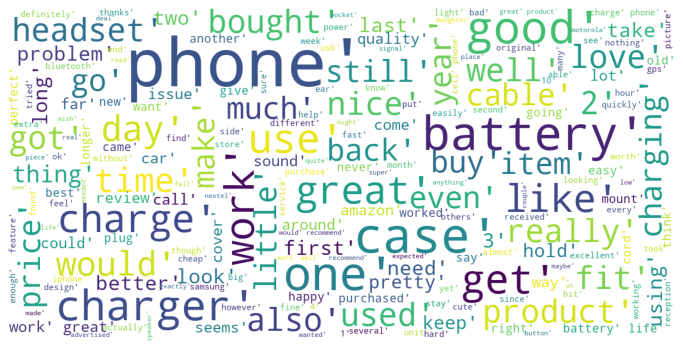

In [ ]:
wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(cluster1_lemmas))

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')

plt.imshow(wordcloud)
plt.show()

In [ ]:

w2v_model.save("/content/drive/MyDrive/word2vec.model")

In [ ]:
wv_model = Word2Vec.load("/content/drive/MyDrive/word2vec.model")

In [ ]:
kmeans_model = KMeans(n_clusters=2, max_iter=500, random_state=111).fit(X=wv_model.wv.vectors.astype('double'))

In [ ]:
wv_model.wv.similar_by_vector(kmeans_model.cluster_centers_[0], topn=10, restrict_vocab=None)

[('estafa', 0.8835477828979492),
 ('buenisimos', 0.8699852824211121),
 ('(*;*)', 0.8544617891311646),
 ('satis', 0.8459377884864807),
 ('quieran', 0.8384619951248169),
 ('exellente', 0.8304758071899414),
 ('ecxelente', 0.8210066556930542),
 ('goegeous', 0.8207131624221802),
 ('fecho', 0.8174947500228882),
 ('quedado', 0.8172032833099365)]

In [ ]:
wv_model.wv.similar_by_vector(kmeans_model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('side', 0.7434924840927124),
 ('plastic', 0.7400757670402527),
 ('rubber', 0.7020939588546753),
 ('cover', 0.6512306332588196),
 ('slide', 0.6486599445343018),
 ('corner', 0.6467921733856201),
 ('surface', 0.6435797214508057),
 ('hard', 0.6375513076782227),
 ('bottom', 0.6216148138046265),
 ('part', 0.615565836429596)]